In [1]:
import numpy as np
import pandas as pd
import torchvision
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [2]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size).to('cuda'),
                            torch.zeros(1,1,self.hidden_layer_size).to('cuda'))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp

In [5]:
a = -0.025794
c = 0.02
b1 = 0.0135
b2 = 0.0065
k = 0.129
sigma = 1
alpha = 0.35
eps = 1
beta = 10e-8
q=1.6

In [6]:
def FHN(self, X):
        x1, y1, x2, y2 = X
        return [x1*(a-x1)*(x1-1) - y1 + k*(x2-x1),
                b1*x1 - c*y1,
                x2*(a-x2)*(x2-1) - y2 + k*(x1-x2),
                b2*x2 - c*y2
               ]

In [7]:
sol = solve_ivp(FHN, [0, 25000], [-0.1, -0.1, -0.1, -0.1], 
                t_eval=np.array(range(0, 25000, 2)), rtol = 1e-11, atol = 1e-11, dense_output=True)

Text(0, 0.5, 'x1')

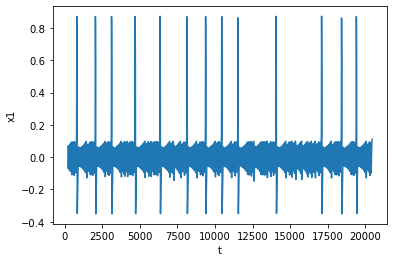

In [8]:
plt.plot(sol.t[100:10230],sol.y[0][100:10230])
plt.xlabel('t')
plt.ylabel('x1')

In [9]:
train = sol.y[0][100:10218]
test = sol.y[0][10218:] 

mean = train.mean()
std = train.std()

#scaler = MinMaxScaler(feature_range=(-1, 1))
#train_norm = scaler.fit_transform(train.reshape(-1, 1))
#test_norm = scaler.transform(test.reshape(-1, 1))
#sigmastest = np.abs(test - mean)
train_norm = (train - mean)/std
test_norm = (test - mean)/std

In [10]:
train_norm = torch.FloatTensor(train_norm).view(-1)
test_norm = torch.FloatTensor(test_norm).view(-1)

In [14]:
train_window = 40

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [64]:
train_inout_seq = create_inout_sequences(train_norm, train_window)

In [15]:
from IPython.display import clear_output

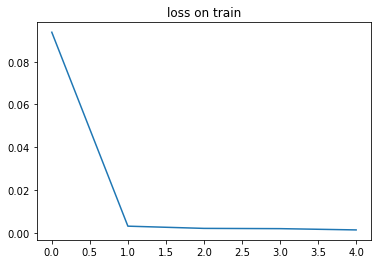

0.0013112978926189066


In [66]:
epochs = 5
model = LSTM().to('cuda')
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
losses = []
model.train()
for i in range(epochs):
    if i> 0 and i % 10 == 0:
        learning_rate *= 0.5
    epoch_loss = []
    for seq, label in train_inout_seq:
        optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to('cuda'),
                        torch.zeros(1, 1, model.hidden_layer_size).to('cuda'))
        y_pred = model(seq.to('cuda'))

        single_loss = nn.MSELoss()(y_pred, label.to('cuda'))
        single_loss.backward()
        optimizer.step()
        epoch_loss.append(single_loss.item())

        
    clear_output(True)
    losses.append(np.mean(epoch_loss))
    plt.title("loss on train")
    plt.plot(losses)
    plt.show()
    print(losses[-1])

In [67]:
fut_pred = 40

test_inputs = train_norm[-train_window:].tolist()
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:]).to('cuda')
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size).to('cuda'),
                        torch.zeros(1, 1, model.hidden_layer_size).to('cuda'))
        test_inputs.append(model(seq).item())

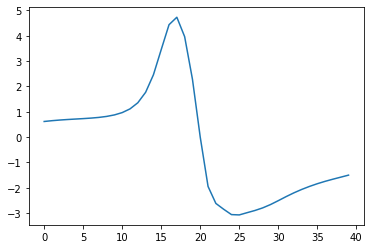

In [68]:
plt.plot(test_inputs[40:])

In [43]:
train_norm[6000:6500].min()

tensor(-0.6682)

In [45]:
test_norm[:20]

tensor([-0.2819, -0.2756, -0.2704, -0.2663, -0.2633, -0.2612, -0.2598, -0.2588,
        -0.2577, -0.2559, -0.2521, -0.2446, -0.2304, -0.2042, -0.1556, -0.0643,
         0.1086,  0.4111,  0.7768,  0.9720])

In [44]:
test_inputs[20:40]

[-0.2874065041542053,
 -0.29074883460998535,
 -0.2943924069404602,
 -0.29776573181152344,
 -0.3010562062263489,
 -0.3043469190597534,
 -0.30764907598495483,
 -0.31096363067626953,
 -0.31428903341293335,
 -0.3176223039627075,
 -0.3209591507911682,
 -0.3242942690849304,
 -0.3276214599609375,
 -0.33093345165252686,
 -0.33422207832336426,
 -0.3374784588813782,
 -0.3406928777694702,
 -0.34385526180267334,
 -0.34695547819137573,
 -0.34998297691345215]

In [69]:
true_evol = train_norm

In [70]:
len(true_evol)

10118

In [71]:
model_test = LSTM()
model_test.load_state_dict(model.state_dict())
model_test.to('cuda')
model_test.hidden_cell = (torch.zeros(1, 1, model_test.hidden_layer_size).to('cuda'),
                        torch.zeros(1, 1, model_test.hidden_layer_size).to('cuda'))

In [72]:
predicted = []

for step in range(0, len(test_norm), train_window):
    fut_pred = 7
    true_evol_per_step = test_norm[step: step + train_window]
    test_inputs = true_evol[-train_window:].tolist()
    model_test.eval()
    
    for i in range(fut_pred):
        seq = torch.FloatTensor(test_inputs[-train_window:]).to('cuda')
        with torch.no_grad():
            model_test.hidden = (torch.zeros(1, 1, model_test.hidden_layer_size).to('cuda'),
                            torch.zeros(1, 1, model_test.hidden_layer_size).to('cuda'))
            test_inputs.append(model_test(seq).item())
    predicted += test_inputs[train_window:]
    
    if len(true_evol_per_step) == train_window:
        model_test.train()
        test_inout_seq = create_inout_sequences(true_evol_per_step, train_window)
        for seq, labels in test_inout_seq:
            optimizer.zero_grad()
            model_test.hidden_cell = (torch.zeros(1, 1, model_test.hidden_layer_size).to('cuda'),
                                torch.zeros(1, 1, model_test.hidden_layer_size).to('cuda'))
            y_pred = model_test(seq.to('cuda'))

            single_loss = nn.MSELoss()(y_pred, labels.to('cuda'))
            single_loss.backward()
            optimizer.step()
    true_evol = torch.cat((true_evol, true_evol_per_step))

In [19]:
def test_window_size(size):
    train_inout_seq = create_inout_sequences(train_norm, size)
    epochs = 5
    model = LSTM().to('cuda')
    optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
    learning_rate = 0.001
    losses = []
    for i in range(epochs):
        epoch_loss = []
        for seq, label in train_inout_seq:
            #learning_rate *= 0.5
            optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
            optimizer.zero_grad()
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to('cuda'),
                            torch.zeros(1, 1, model.hidden_layer_size).to('cuda'))
            y_pred = model(seq.to('cuda'))

            single_loss = nn.MSELoss()(y_pred, label.to('cuda'))
            single_loss.backward()
            optimizer.step()
            epoch_loss.append(single_loss.item())


        clear_output(True)
        losses.append(np.mean(epoch_loss))
        plt.title("loss on train")
        plt.plot(losses)
        plt.show()
        print(losses[-1])

    true_evol = train_norm
    predicted = []
    fut_pred = 7
    for step in range(0, len(test_norm), fut_pred):
        true_evol_per_step = test_norm[step: step + fut_pred]
        test_inputs = true_evol[-size:].tolist()
        model.eval()

        for i in range(fut_pred):
            seq = torch.FloatTensor(test_inputs[-size:]).to('cuda')
            with torch.no_grad():
                model.hidden = (torch.zeros(1, 1, model.hidden_layer_size).to('cuda'),
                                torch.zeros(1, 1, model.hidden_layer_size).to('cuda'))
                test_inputs.append(model(seq).item())
        predicted += test_inputs[size:]
        
        true_evol = torch.cat((true_evol, true_evol_per_step))

        
        model.train()
        test_inout_seq = create_inout_sequences(true_evol[-size:], size)
        for seq, labels in test_inout_seq:
            optimizer.zero_grad()
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to('cuda'),
                                torch.zeros(1, 1, model.hidden_layer_size).to('cuda'))
            y_pred = model(seq.to('cuda'))
            single_loss = nn.MSELoss()(y_pred, labels.to('cuda'))
            single_loss.backward()
            optimizer.step()
        
    plt.plot(predicted)

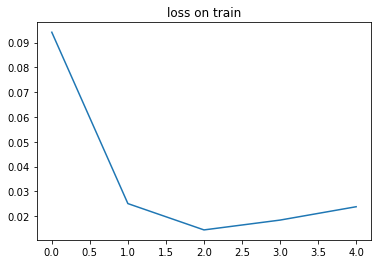

0.02382987996504236


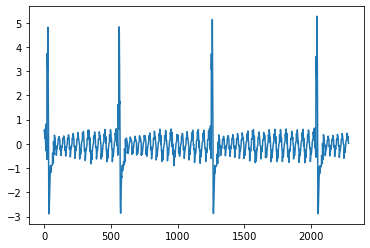

In [20]:
test_window_size(20)

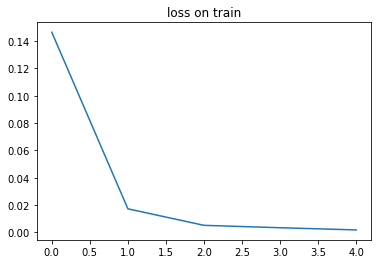

0.0018320313477858347


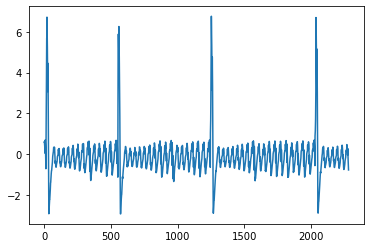

In [21]:
test_window_size(30)

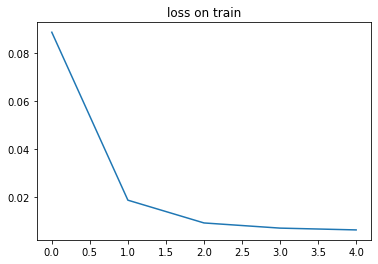

0.006324700955278187


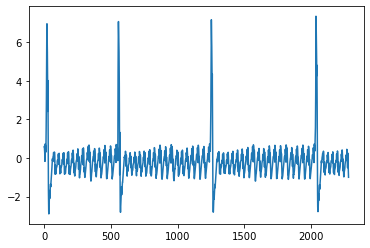

In [22]:
test_window_size(40)

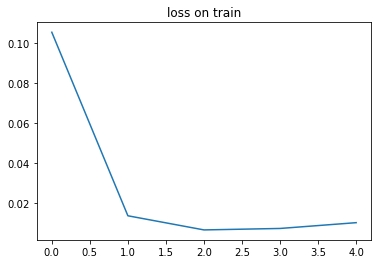

0.010117597721922297


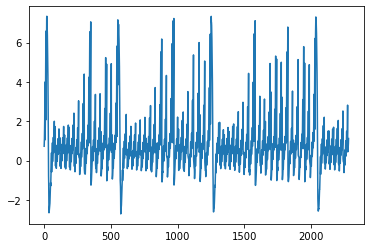

In [23]:
test_window_size(50)

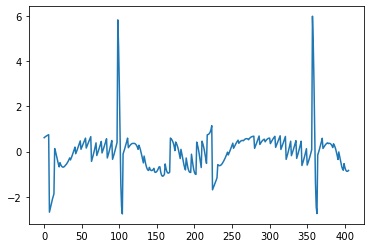

In [73]:
plt.plot(predicted)

In [252]:
len(true_evol)

12400

In [30]:
predicted

[-0.28083232045173645,
 -0.2781691253185272,
 -0.2852184474468231,
 -0.3043537139892578,
 -0.3351193964481354,
 -0.3777504563331604,
 -0.4328705668449402,
 -0.4981294870376587,
 -0.5665013790130615,
 -0.6299400329589844,
 -0.6836214661598206,
 -0.7271395325660706,
 -0.762722373008728,
 -0.7927835583686829,
 -0.8188215494155884,
 -0.8415041565895081,
 -0.8611176013946533,
 -0.8777932524681091,
 -0.8915459513664246,
 -0.9023662209510803,
 0.8675659894943237,
 0.7433639168739319,
 0.61821448802948,
 0.4537748396396637,
 0.2378138303756714,
 -0.08138487488031387,
 -0.5449763536453247,
 -0.9311510920524597,
 -1.186600685119629,
 -1.4074485301971436,
 -1.5905563831329346,
 -1.7342748641967773,
 -1.8387929201126099,
 -1.8868147134780884,
 -1.9133301973342896,
 -1.9313915967941284,
 -1.947511076927185,
 -1.9711819887161255,
 -2.0192298889160156,
 -2.062382221221924,
 -0.9260802865028381,
 -0.9764562249183655,
 -1.051385521888733,
 -1.1313647031784058,
 -1.2180243730545044,
 -1.299889087677002,

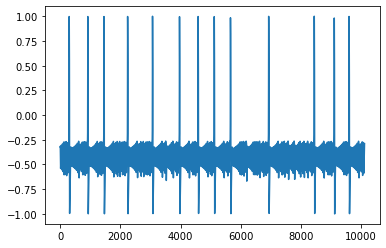

In [31]:
plt.plot(train_norm)

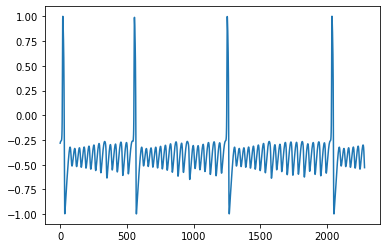

In [11]:
plt.plot(test_norm)

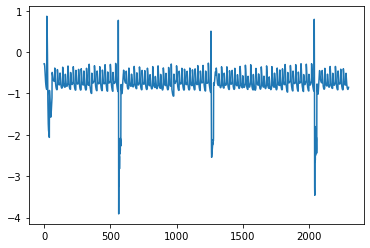

In [29]:
plt.plot(predicted)

In [288]:
predicted[540:600]

[0.7254955768585205,
 0.759441077709198,
 0.8165570497512817,
 0.9066677689552307,
 1.0596500635147095,
 1.3597785234451294,
 2.053805351257324,
 3.542520523071289,
 5.817389011383057,
 7.216159820556641,
 7.410839557647705,
 7.430907726287842,
 7.428900718688965,
 7.428427696228027,
 7.42883825302124,
 7.428889274597168,
 7.428878307342529,
 7.428896903991699,
 7.428868770599365,
 7.428895950317383,
 7.364964485168457,
 7.422447681427002,
 7.4313249588012695,
 7.429101467132568,
 7.428415298461914,
 6.4967942237854,
 6.403209209442139,
 6.394354820251465,
 5.8704328536987305,
 5.772806644439697,
 5.774835586547852,
 5.771492004394531,
 5.772113800048828,
 4.77903413772583,
 4.435580730438232,
 4.254242420196533,
 4.127035140991211,
 4.041009426116943,
 4.017014503479004,
 4.00699520111084,
 -2.221782684326172,
 -2.3046770095825195,
 -2.378777503967285,
 -2.4135990142822266,
 -2.271876811981201,
 -2.0543274879455566,
 -1.7386926412582397,
 -1.556733250617981,
 -1.5152684450149536,
 -1.

In [255]:
len(predicted)

2300

In [256]:
(len(test))

2282

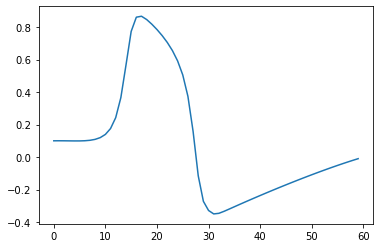

In [275]:
plt.plot(test[540:600])

In [233]:
train_norm.max()

tensor(7.2043)

In [17]:
train_norm[6000:6500].max()

tensor(0.7050)

In [15]:
test_inputs[20:40]

[0.616908073425293,
 0.6662673950195312,
 0.7360585927963257,
 0.8477460145950317,
 1.0375640392303467,
 1.382082462310791,
 2.077755928039551,
 3.553882360458374,
 5.988043308258057,
 7.623494625091553,
 7.865307807922363,
 7.769824504852295,
 7.305576801300049,
 6.853262901306152,
 6.533700942993164,
 6.257808208465576,
 5.98073148727417,
 5.655295372009277,
 5.201878547668457,
 4.45725679397583]

In [16]:
test_inputs

[-0.809381902217865,
 -0.7330803871154785,
 -0.6515586376190186,
 -0.5671824216842651,
 -0.48149025440216064,
 -0.39551928639411926,
 -0.31000402569770813,
 -0.2254968136548996,
 -0.142441987991333,
 -0.0612218864262104,
 0.017813704907894135,
 0.09432881325483322,
 0.16798919439315796,
 0.238455131649971,
 0.3053778409957886,
 0.368399441242218,
 0.427156001329422,
 0.4812846779823303,
 0.5304350256919861,
 0.5742854475975037,
 0.616908073425293,
 0.6662673950195312,
 0.7360585927963257,
 0.8477460145950317,
 1.0375640392303467,
 1.382082462310791,
 2.077755928039551,
 3.553882360458374,
 5.988043308258057,
 7.623494625091553,
 7.865307807922363,
 7.769824504852295,
 7.305576801300049,
 6.853262901306152,
 6.533700942993164,
 6.257808208465576,
 5.98073148727417,
 5.655295372009277,
 5.201878547668457,
 4.45725679397583]

In [57]:
np.max(test_inputs[:60])

7.430398941040039

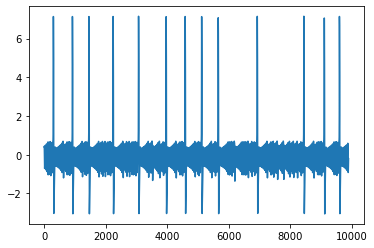

In [67]:
plt.plot(train_norm)

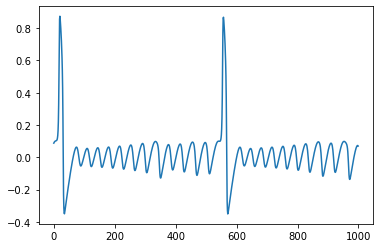

In [44]:
plt.plot(test[:1000])

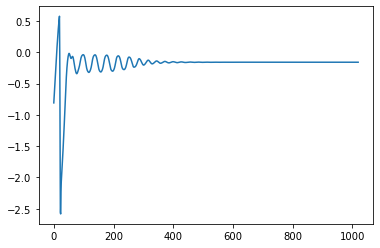

In [43]:
plt.plot(test_inputs)

In [38]:
losses = []
model = LSTM()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
for epoch in range(20):
    for x, y in zip(X_train, Y_train):
        optimizer.zero_grad()
        x = torch.from_numpy(np.expand_dims(np.array([x]), axis=0)).type(torch.FloatTensor)
        y = torch.from_numpy(np.expand_dims(np.array([y]), axis=0)).type(torch.FloatTensor)
        y_pred = model(x)
        loss = nn.MSELoss()(y_pred, y)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        plt.plot(range(len(losses)), losses)
        plt.ylabel("loss")
        plt.xlabel("epochs")

RuntimeError: input must have 3 dimensions, got 2